In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

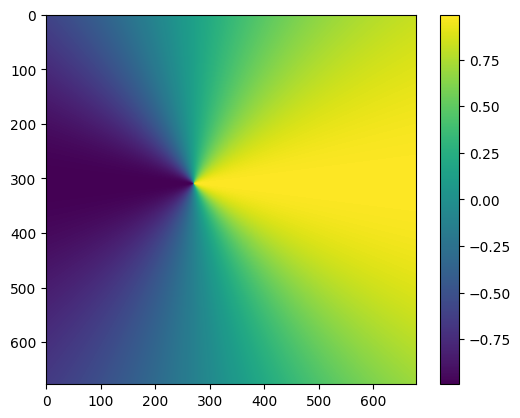

In [2]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()


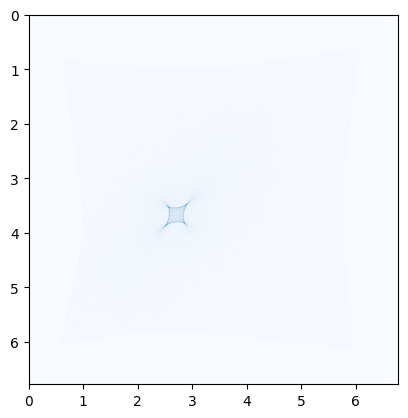

In [3]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
plt.gca().invert_yaxis()

In [17]:
beta = (270.8,305.5) #in pixel
z_s = 1.0
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale, diff_z = False)


Image 1 position: [1.89209435 3.72020167]
Predicted Image 1 position: [1.89207518 3.72018152]
Difference: 2.781130120625902e-05
Image 2 position: [1.9469953  2.52910089]
Predicted Image 2 position: [1.9470094  2.52906798]
Difference: 3.580378664177848e-05
Image 3 position: [3.25530863 3.79938642]
Predicted Image 3 position: [3.25529017 3.79941815]
Difference: 3.670585383906345e-05
Image 4 position: [3.39606342 2.25730765]
Predicted Image 4 position: [3.39607388 2.25730644]
Difference: 1.0524494198733463e-05


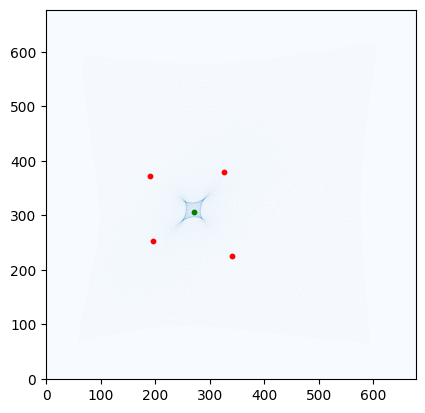

In [18]:
# lenstronomy
solver = LensEquationSolver(lensModel)
thetax, thetay = solver.image_position_analytical(beta[0], beta[1], kwargs_lens)

theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i], thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical * pixscale, key=lambda x: x[0])  # sort by x coordinate

# my class
theta_numerical = np.array(cluster.get_image_positions())
sorted_theta_numerical = sorted(theta_numerical, key=lambda x: x[0])  # sort by x coordinate
plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
plt.scatter(thetax, thetay, color='red', s=10)
plt.scatter(beta[0], beta[1], color='green', s=10)
plt.imshow(array_test, cmap='Blues')
plt.gca().invert_yaxis()


for i in range(len(sorted_theta_analytical)):
    print(f'Image {i+1} position: {sorted_theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    print(f'Difference: {np.sqrt((sorted_theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (sorted_theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')   



In [19]:
z_s = [1.0, 1.5, 2.0, 2.5]
z_l = 0.5
beta_scaled = np.array(beta)*pixscale
for z_s_i in z_s:
    clusterr = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s_i, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale, diff_z = True)
    theta_test = clusterr.get_image_positions()
    print(theta_test)

alpha_test = (3.3960634218484116 - beta_scaled[0], 2.2573076492907695 - beta_scaled[1])
print(alpha_test)
print(beta_scaled[0] + 0.6337383137658482 *alpha_test[0], beta_scaled[1] + 0.6337383137658482 *alpha_test[1])

Scaling factor: 1.0
[(3.3960634219090027, 2.2573076493895385), (1.9469953018476813, 2.529100891147599), (1.8920943528136125, 3.7202016713433887), (3.2553086347280833, 3.7993864222395675)]
Scaling factor: 0.7551897621430999
[(3.215362115823544, 2.4427324836274553), (2.105698249255134, 2.696305962860939), (2.072210126753671, 3.530306708330636), (3.0967519222850433, 3.635976254772663)]
Scaling factor: 0.6741560129448375
[(3.155814718737072, 2.504478271637155), (2.158103682615601, 2.753335009975681), (2.1313834803458374, 3.4656619453496256), (3.0444938841869544, 3.581308276423446)]
Scaling factor: 0.6337383137658482
[(3.1261847306651034, 2.5353705362379375), (2.1841687394286944, 2.7824228694556057), (2.160794507393018, 3.4328559857089274), (3.0184067679849154, 3.5539456127549274)]
(0.6880634218484114, -0.7976923507092306)
3.144052152726172 2.5494717947576166


In [20]:
print("Numerical:")
mag_table = cluster.get_magnifications() #output a dataframe
print(mag_table)

# Analytical magnifications
data_analytical = []
lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
for i in range(len(thetax)):
    x, y = thetax[i], thetay[i]
    mag = lensModel.magnification(thetax[i], thetay[i], kwargs_lens)
    data_analytical.append({'x': x * pixscale, 'y': y * pixscale, 'magnification': mag})
    

table_analytical = pd.DataFrame(data_analytical)
pd.options.display.float_format = '{:.12f}'.format
table_analytical = table_analytical.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table_analytical)

Numerical:
               x              y   magnification
0 1.892094352512 3.720201670935  5.091469424524
1 1.946995301807 2.529100891151 -3.615467708108
2 3.255308634727 3.799386422286 -2.745951608123
3 3.396063421541 2.257307649040  3.975096550057
Analytical:
               x              y   magnification
0 1.892075184005 3.720181520760  5.141680758481
1 1.947009396726 2.529067978440 -3.554982648379
2 3.255290173648 3.799418147829 -2.775686125047
3 3.396073876725 2.257306441534  3.983078333641


In [44]:
# default time delay
print("Numerical:")
theta = cluster.get_image_positions()
dt = cluster.get_time_delays(theta)
print(dt)


'''data_dt = []
for i in range(len(theta_numerical)):
    x, y = theta_numerical[i]
    delay = dt[i]       # in days
    data_dt.append({'x': x, 'y': y, 'delta_t': delay})

table = pd.DataFrame(data_dt)
pd.options.display.float_format = '{:.12f}'.format
table = table.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table)'''


# restore the lens model in arcsec
kwargs_sie1 = {'theta_E': theta_E * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0] * pixscale, 'center_y': len_coord[1] * pixscale}
kwargs_lens1 = [kwargs_sie1]


lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
thetax, thetay = solver.image_position_analytical(beta[0]* pixscale, beta[1]*pixscale, kwargs_lens1)
print(beta[0]* pixscale, beta[1]*pixscale)
t_analytical = lensModel.arrival_time(thetax , thetay , kwargs_lens1, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
print(t_analytical)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - t_analytical[0]

data_dt_analytical = []
for i in range(len(thetax)):
    x, y = theta_analytical[i] * pixscale
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)

Numerical:
         theta_x        theta_y       d_fermat   delta_t(days)
0 3.396063421803 2.257307649258 0.000000000000  0.000000000000
1 1.892094353164 3.720201671734 0.078647140832  9.709419521474
2 1.946995301838 2.529100891150 0.150846614087 18.622839229337
3 3.255308634674 3.799386422319 0.198555552953 24.512768570267
Analytical:
2.708 3.055
[-76.14475179 -66.10223694 -56.88173874 -50.78886134]
         theta_x        theta_y         delta_t
0 3.396073876725 2.257306441534  0.000000000000
1 1.892075184005 3.720181520760 10.042514855051
2 1.947009396726 2.529067978440 19.263013053621
3 3.255290173648 3.799418147829 25.355890455750


In [55]:

#test multiple source plane lensing code
# assume the default lens and source position are z_l = 0.5, z_s = 1.0 and thete_E = 1.0
z_l = 0.5
z_s = 0.6664240863354766

#numerical stuffs
cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale, diff_z = True)
print("Numerical:")
theta = cluster_mp.get_image_positions()
dt = cluster_mp.get_time_delays(theta)
print(dt)

# analytical stuffs
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(H0=70, Om0=0.3)

D_S1 = cosmos.angular_diameter_distance(1.0)
D_S2 = cosmos.angular_diameter_distance(z_s)
D_LS1 = cosmos.angular_diameter_distance_z1z2(z_l, 1.0)
D_LS2 = cosmos.angular_diameter_distance_z1z2(z_l, z_s)
factor =  D_LS1 * D_S2 / D_S1 / D_LS2
kwargs_sie2 = {'theta_E': theta_E*factor * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens_mp = [kwargs_sie2]
lensModel2 = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
solver2 = LensEquationSolver(lensModel2)

print("Analytical:")

thetax, thetay = solver2.image_position_analytical(beta[0]* pixscale, beta[1]* pixscale, kwargs_lens_mp)
t_analytical = lensModel2.arrival_time(thetax, thetay, kwargs_lens_mp, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
min_t = min(t_analytical)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - min_t
data_dt_analytical = []
for i in range(len(thetax)):
    x, y = thetax[i] , thetay[i]
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)



Numerical:
         theta_x        theta_y           d_fermat    delta_t(days)
0 0.978462081411 5.196251055177                0.0   0.000000000000
1 3.069761265235 1.694258555285  2.622570222366487 643.790937601924
Analytical:
         theta_x        theta_y          delta_t
0 0.978462863962 5.196254159732   0.000000000000
1 3.069780894530 1.694262100588 666.014411673516


In [9]:
# comparing speed 
#comparing time
import time
start = time.time()
cluster.get_time_delays()
end = time.time()
print("Time taken for my time delay: ", end-start)
start = time.time()
theta = np.array(cluster.get_image_positions())
lensModel.arrival_time(theta[0][0] / pixscale, theta[0][1]/pixscale, kwargs_lens)
end = time.time()
print("Time taken for lenstronomy time delay: ", end-start)

TypeError: ClusterLensing.get_time_delays() missing 1 required positional argument: 'theta'

In [98]:
import time
beta_test = (2.4256278669405678, 3.725267541907791)
z_l = 0.5
z_s = 1.0
start = time.time()
test = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta_test[0], beta_test[1], diff_z = False)
theta = np.array(test.get_image_positions())
end = time.time()
print("Time taken for my image position: ", end-start)
start = time.time()
mag = cluster.get_magnifications()
end = time.time()
print("Time taken for my magnification: ", end-start)
start = time.time()
dt = cluster.get_time_delays(theta)
end = time.time()
print("Time taken for my time delay: ", end-start)

Time taken for my image position:  0.6130156517028809
Time taken for my magnification:  0.8298194408416748
Time taken for my time delay:  0.0016372203826904297


In [14]:
def generate_random_coordinates(num_points, x_bound, y_bound):
    x_coords = np.random.uniform(x_bound[0], x_bound[1], num_points)
    y_coords = np.random.uniform(y_bound[0], y_bound[1], num_points)
    return x_coords, y_coords

In [26]:
# population of time delays
# test the time delay population
import numpy as np



# generate beta population in arcsec
num_points = 500
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
z_l = 0.5
z_s = 0.6
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)

dt_pop = []
'''for i in tqdm(range(num_points)):
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, betax[i], betay[i], diff_z = False)
    theta = np.array(cluster_mp.get_image_positions())
    dt = cluster_mp.get_time_delays(theta)
    dt_value = dt['delta_t(days)'].values.tolist()
    dt_value = [value for value in dt_value if value != 0]
    dt_pop.append(dt_value)
    #print(dt['delta_t(days)'])'''

for i in tqdm(range(num_points)):
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, betax[i], betay[i], diff_z = True)
    theta = np.array(cluster_mp.get_image_positions())
    t = lensModel.arrival_time(theta[:,0], theta[:,1], kwargs_lens1)
    if len(t) == 0:
        continue
    min_t = min(t)
    dt = [t_i - min_t for t_i in t if t_i - min_t != 0]
    dt_pop.append(dt)
print(dt_pop)

100%|██████████| 500/500 [06:00<00:00,  1.39it/s]

[[], [], [], [], [], [], [124.0101257843888], [], [], [], [], [], [], [], [49.11564951981621], [], [], [], [132.79354078223727], [81.89504984889749], [88.58015696862462], [], [], [74.56266329363906], [], [72.74630286691337], [], [], [64.60516110507757], [15.613887823443726, 17.074699976576582, 27.863384208428407], [142.42987739626102], [], [], [169.4702371627374], [], [], [], [], [], [], [], [], [], [], [120.3701726370472], [], [88.16496184640866], [103.2849292204127], [], [], [], [], [], [], [], [185.2003239616452], [], [], [], [], [], [], [], [], [], [126.88598039888316], [], [], [], [], [], [], [], [], [132.16318005325098], [], [], [], [], [], [], [], [], [], [], [], [], [73.83074728769814], [173.72082956146838], [], [], [], [], [166.9269110041194], [101.5872260120361], [], [], [], [72.57704799044477], [], [], [], [], [73.66879058520881], [], [], [], [80.6928168433198], [], [], [], [], [33.836863849628045], [], [69.79543339632019], [], [], [], [], [], [], [], [], [], [130.3599411778

(array([ 6.,  4.,  5.,  4.,  2.,  7.,  2., 10.,  7.,  9.,  7.,  7.,  6.,
         4.,  5.,  7.,  1.,  3.,  1.,  3.,  1.]),
 array([  6.52542764,  15.03375604,  23.54208443,  32.05041283,
         40.55874123,  49.06706962,  57.57539802,  66.08372641,
         74.59205481,  83.10038321,  91.6087116 , 100.11704   ,
        108.6253684 , 117.13369679, 125.64202519, 134.15035358,
        142.65868198, 151.16701038, 159.67533877, 168.18366717,
        176.69199557, 185.20032396]),
 <BarContainer object of 21 artists>)

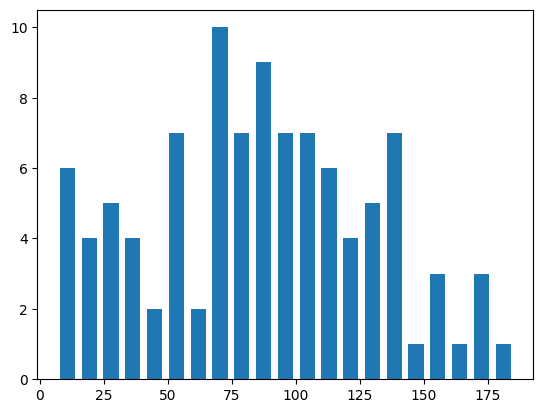

In [27]:
dt_pop_hist = np.concatenate(dt_pop)
plt.hist(dt_pop_hist, bins=21,rwidth=0.7)

In [54]:
# inject stimulated GW events to the time delay population
import pandas as pd
# random select 1000 events and points
num_points = 100
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)
injections = pd.read_csv("injections_summary_O4_0")
injections = injections.sample(n=100)
injections_para = injections[['dl', 'snr', 'z']].copy()
injections_para.insert(0, 'x', betax)
injections_para.insert(1, 'y', betay)
injections_para = injections_para[injections_para['z'] > 0.5].reset_index(drop=True)
print(injections_para['z'].values.tolist())
#print(injections_para)
z_l = 0.5
z_s = injections_para['z'].values.tolist()
betax = injections_para['x'].values.tolist()
betay = injections_para['y'].values.tolist()
snr = injections_para['snr'].values.tolist()
dt_pop = []
for i in tqdm(range(len(z_s))):
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s[i], pixscale, 678, betax[i], betay[i], diff_z = True)
    mag = cluster_mp.get_magnifications() # a table of theta and mag
    if len(mag) == 0:
        continue
    snr_i = snr[i]
    
    for mag_i in mag['magnification']:
        if snr_i * np.sqrt(abs(mag_i)) < 8:
            mag.drop(mag[mag['magnification'] == mag_i].index)
    theta = list(zip(mag['x'].tolist(), mag['y'].tolist()))
    dt = cluster_mp.get_time_delays(theta) # ok
    dt_value = dt['delta_t(days)'].values.tolist() # ok
    dt_value = [value for value in dt_value if value != 0] # ok
    dt_pop.append(dt_value) # ok
    



[1.7007924078024277, 0.972589064759201, 2.170767958071154, 1.354951583235804, 1.9638423449343172, 1.4251261241873296, 1.5149343031748477, 2.2629520924762088, 1.3705609922106423, 2.0513206795196384, 0.97421498773655, 1.3941286650228648, 0.8611348250669341, 1.493629064048113, 0.8577055264820286, 1.3529832221644893, 2.084061301158937, 1.628497963874309, 2.0808235585735786, 1.4881001200840176, 1.1748615730555352, 0.5550571962255043, 1.712508701405524, 0.8272591348904922, 0.9392455607606428, 0.7751342426831556, 1.3834880002461811, 2.245343781085088, 0.9122986268086902, 0.6664240863354766, 1.1791119846229012, 0.7000109597567091, 0.9574418873802047, 1.0604050422953073, 1.8340182838032584, 2.0995706474204923, 0.8001423620324642, 1.9658450714519995, 1.992346259843441, 1.7378652368039849, 2.068276461746, 1.3551567587883786, 1.7824893895700518, 0.719263507185799, 2.214419963546467, 1.0721347482549917, 2.1457910595875918, 1.207936501319309, 1.492127512100824, 2.3445260243737205, 1.5551569472380884

 36%|███▌      | 30/84 [00:18<00:34,  1.57it/s]

2.3430724383712818 3.607168240074462 0.6664240863354766


 38%|███▊      | 32/84 [00:19<00:33,  1.56it/s]

2.493745608781893 3.8352113592411428 0.7000109597567091


 63%|██████▎   | 53/84 [00:32<00:19,  1.56it/s]

2.027324358791506 2.8660570050636975 0.6661845881934386


 65%|██████▌   | 55/84 [00:34<00:18,  1.54it/s]

2.708399863104576 3.476411795304853 0.6095357156965342


100%|██████████| 84/84 [00:52<00:00,  1.60it/s]


(array([3., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]),
 array([   6.27894621,   64.32305156,  122.3671569 ,  180.41126224,
         238.45536758,  296.49947292,  354.54357826,  412.5876836 ,
         470.63178894,  528.67589428,  586.71999962,  644.76410497,
         702.80821031,  760.85231565,  818.89642099,  876.94052633,
         934.98463167,  993.02873701, 1051.07284235, 1109.11694769,
        1167.16105303, 1225.20515837]),
 <BarContainer object of 21 artists>)

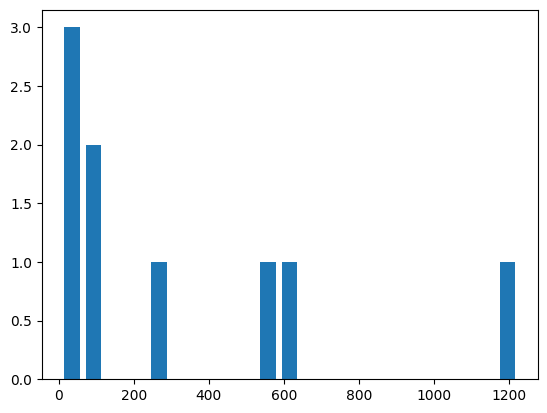

In [37]:
dt_pop_hist = np.concatenate(dt_pop)
plt.hist(dt_pop_hist, bins=21,rwidth=0.7)

[0.55, 1.5, 1.3, 1.3, 1.6, 2.2, 1.75, 2.05, 2.4, 2.35, 2.0, 0.9, 1.85, 1.9, 1.85, 2.0, 2.15, 0.85, 1.55, 2.1, 1.15, 1.55, 0.6, 1.05, 0.95, 1.55, 1.95, 1.65, 1.6, 1.3, 2.1, 1.25, 1.0, 0.55, 2.0, 0.6, 1.75, 2.05, 1.0, 0.55, 1.35, 2.35, 1.1, 2.15, 2.0, 1.35, 1.8, 0.95, 1.9, 1.9, 1.7, 2.25, 1.05, 2.2, 1.65, 2.35, 2.05, 2.2, 1.05, 1.9, 1.4, 1.2, 1.7, 0.85, 2.1, 0.7, 0.7, 1.75, 1.05, 1.1, 1.95, 1.85, 1.15, 2.35, 0.95, 1.45, 0.85, 1.0, 1.85, 2.05, 1.0, 2.1, 1.85, 2.4, 1.0, 2.05, 1.9, 2.35, 2.35, 1.35, 1.5, 1.85, 2.0, 1.85, 1.15, 2.2, 1.85, 0.75, 0.95, 2.15, 0.55, 0.6, 1.5, 1.65, 0.55, 1.55, 1.4, 1.85, 1.55, 1.1, 1.8, 0.55, 1.65, 1.0, 1.1, 2.2, 2.4, 1.6, 1.45, 2.0, 1.2, 1.15, 1.6, 0.6, 1.3, 2.4, 2.25, 2.35, 1.45, 0.8, 1.9, 1.5, 1.35, 2.2, 0.65, 1.4, 0.6, 2.4, 0.95, 1.25, 2.3, 0.65, 1.25, 1.0, 0.7, 2.0, 2.1, 1.85, 1.55, 1.65, 1.2, 1.6, 1.75, 2.15, 1.2, 2.2, 1.5, 2.4, 1.4, 2.3, 1.1, 1.35, 1.75, 0.55, 2.2, 0.75, 1.55, 0.65, 0.65, 1.9, 1.75, 0.85, 1.4, 2.0, 1.95, 0.85, 2.4, 1.75, 2.2, 2.35, 1.1, 2

(array([1317., 2766., 2834., 2844., 2881., 3016., 2914., 3006., 3123.,
        3084., 3251., 3203., 3176., 3292., 3370., 3352., 3362., 3337.,
        3373., 3458., 3471., 3456., 3487., 3659., 3596., 3665., 3576.,
        3691., 3490., 3620., 3649., 3723., 3631., 3683., 3662., 3787.,
        3670., 2777.]),
 array([0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925,
        0.975, 1.025, 1.075, 1.125, 1.175, 1.225, 1.275, 1.325, 1.375,
        1.425, 1.475, 1.525, 1.575, 1.625, 1.675, 1.725, 1.775, 1.825,
        1.875, 1.925, 1.975, 2.025, 2.075, 2.125, 2.175, 2.225, 2.275,
        2.325, 2.375, 2.425]),
 <BarContainer object of 38 artists>)

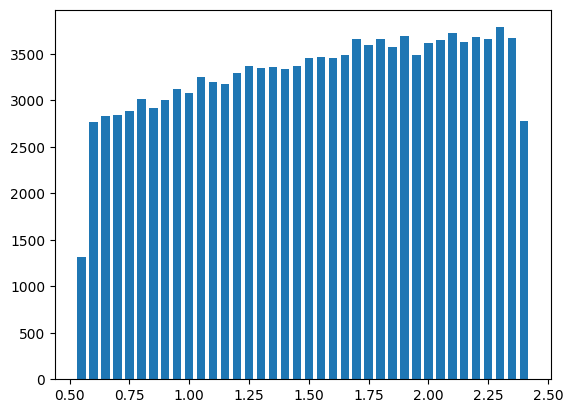

In [81]:
# create new database with z_s values and bin size of 0.05
num_points = 150000
bin_z_s = 0.05
# Rounding function
def round_to_nearest_bin(value, bin_start = 0.55, bin_width = 0.05):
    return round(bin_start + round((value - bin_start) / bin_width) * bin_width,2)


len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)
injections = pd.read_csv("injections_summary_O4_0")
injections = injections.sample(n=num_points)
injections_para = injections[['z', 'snr']].copy()
injections_para.insert(0, 'x', betax)
injections_para.insert(1, 'y', betay)
injections_para = injections_para[injections_para['z'] > 0.55].reset_index(drop=True)

# Add the rounded z values to a new column 'z_s_bin'
injections_para['z_s_bin'] = injections_para['z'].apply(round_to_nearest_bin)
z_l = 0.5
z_s = injections_para['z'].values.tolist()
betax = injections_para['x'].values.tolist()
betay = injections_para['y'].values.tolist()
snr = injections_para['snr'].values.tolist()
z_s_bin = injections_para['z_s_bin'].values.tolist()
# Define the bin centers
bin_centers = np.arange(0.55, max(z_s_bin) + 0.05, 0.05)

# Calculate the bin edges
bin_edges = np.concatenate(([bin_centers[0] - bin_z_s / 2], bin_centers + bin_z_s / 2))

plt.hist(z_s_bin, bins=bin_edges, rwidth=0.7)

In [12]:
# save the new database
f = 3.3960634215107848 - (1-0.7551897621430999)* 0.6880634216
print(f)

3.2276184516082562
